In [13]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Import 
import os 
import time
import numpy as np
import pandas as pd
from scipy import stats
import neuropythy as ny
import matplotlib.pyplot as plt
import scipy.sparse.csgraph as cs
import importlib
from sklearn import linear_model
import plotly.graph_objects as go



# personal import 
from plot_utils_AW import plotly_template, prf_ecc_pcm_plot_matplotlib
from math_utils import weighted_regression, weighted_nan_percentile, weighted_nan_median



In [2]:
# Settings 
subject_id = 111312
hemis = 'lh'
hemis = ['lh','rh']
roi = 'V1'
rois = ['V1', 'V2', 'V3']
plot_groups = [['V1'],['V2'],['V3']]
roi_code = {'V1':1, 
            'V2':2, 
            'V3':3}

num_ecc_pcm_bins = 6
max_ecc = 8

In [3]:
# Import DF 
tsv_dir = '/home/jovyan/projects/pRF-project_NH2025/data/tsv'
# tsv_fn = '{}/{}_prf_parameters.tsv'.format(tsv_dir, subject_id)
tsv_fn_5mm = '{}/{}_prf_parameters_5mm.tsv'.format(tsv_dir, subject_id)

# prf_CM_df = pd.read_table(tsv_fn, sep="\t")
prf_CM_df_5mm = pd.read_table(tsv_fn_5mm, sep="\t")

In [20]:
# Filter data 
th = 100
prf_CM_df_5mm_filter = prf_CM_df_5mm[prf_CM_df_5mm['pRF_CM'] <= th]


In [4]:
roi_colors = {'V1': 'rgb(243, 231, 155)', 
              'V2': 'rgb(250, 196, 132)', 
              'V3': 'rgb(248, 160, 126)'}

# Regression

In [21]:
roi = 'V1'
max_ecc = 8
prf_CM_df_5mm_roi = prf_CM_df_5mm_filter.loc[prf_CM_df_5mm['roi']==roi]

In [22]:
slope, intercept = weighted_regression(prf_CM_df_5mm_roi['prf_ecc'], prf_CM_df_5mm_roi['pRF_CM'], prf_CM_df_5mm_roi['prf_r2'], model='pcm')

In [23]:
# Compute R2 between model cm and data cm
predict_CM = 1 / (slope * prf_CM_df_5mm_roi['prf_ecc'] + intercept)

res = stats.linregress(predict_CM, prf_CM_df_5mm_roi['pRF_CM'])
model_r2 = res.rvalue ** 2

In [24]:
model_x = np.linspace(0,10,100)
model_y = 1 / (slope * model_x + intercept)

# horton
horton_x = prf_CM_df_5mm_roi['prf_ecc']
horton_line = 17.3/(horton_x + 0.75)

res_horton = stats.linregress(horton_line, prf_CM_df_5mm_roi['pRF_CM'])
horton_model_r2 = res_horton.rvalue ** 2

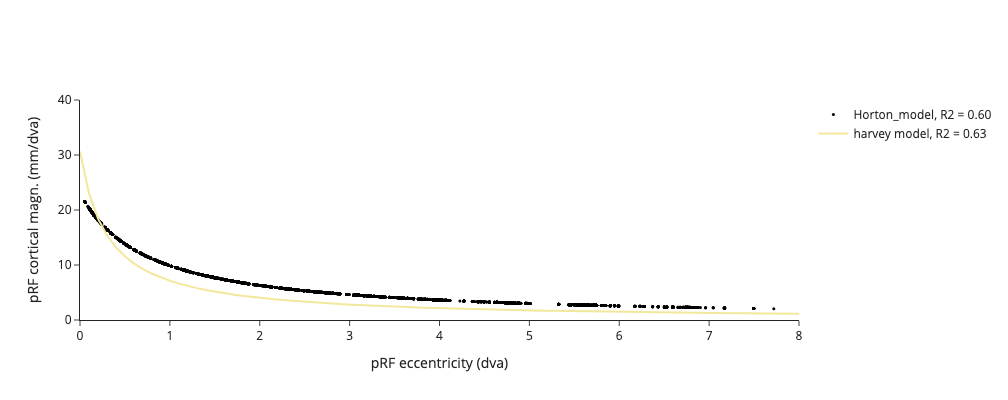

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=horton_x,
                         y=horton_line,
                         mode='markers', 
                         name = 'Horton_model, R2 = {:.2f}'.format(horton_model_r2),
                         marker=dict(color='black', 
                                     symbol='circle', 
                                     size=3), 
                         cliponaxis=False,
                         showlegend=True, 
                         opacity=1))

fig.add_trace(go.Scatter(x=model_x,
                         y=model_y,
                         mode='lines', 
                         name = 'harvey model, R2 = {:.2f}'.format(model_r2),
                         marker=dict(color=roi_colors[roi], 
                                     line=dict(color=roi_colors[roi], width=10)), 
                         cliponaxis=False,
                         showlegend=True, 
                         opacity=1))



fig.update_yaxes(title_text='pRF cortical magn. (mm/dva)', range=[0, 40], showline=True)
fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True)
fig.update_layout(showlegend=True, 
                  template='simple_white', 
                  height=400, 
                  width=800)
fig.show()


## Make DF

## Final plot 

In [4]:
# Figure settings
roi_colors = {'V1': 'rgb(243, 231, 155)', 
              'V2': 'rgb(250, 196, 132)', 
              'V3': 'rgb(248, 160, 126)'}
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)

In [5]:
# fig = prf_ecc_pcm_plot(df_ecc_pcm=prf_CM_df, 
#                        data_pcm_raw=prf_CM_df, 
#                        fig_width=1800, 
#                        fig_height=200, 
#                        rois=rois, 
#                        roi_colors=roi_colors, 
#                        plot_groups=plot_groups, 
#                        max_ecc=max_ecc)

# fig_dir = '/home/jovyan/projects/pRF-project_NH2025/figures/'
# os.makedirs(fig_dir, exist_ok=True)
# fig.write_image("{}/ecc_pcm.pdf".format(fig_dir))

# fig.show()


ValueError: 'color' kwarg must be a color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

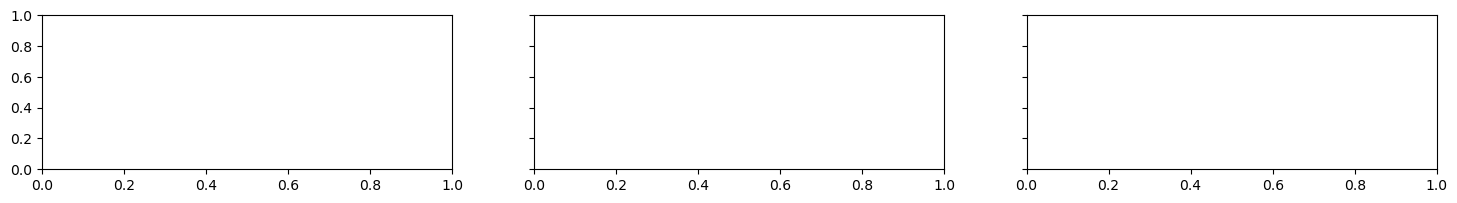

In [6]:
fig = prf_ecc_pcm_plot_matplotlib(df_ecc_pcm=prf_CM_df_5mm, 
                       data_pcm_raw=prf_CM_df_5mm, 
                       fig_width=1800, 
                       fig_height=200, 
                       rois=rois, 
                       roi_colors=roi_colors, 
                       plot_groups=plot_groups, 
                       max_ecc=max_ecc)

fig_dir = '/home/jovyan/projects/pRF-project_NH2025/figures/'
os.makedirs(fig_dir, exist_ok=True)
fig.write_image("{}/ecc_pcm_5mm.pdf".format(fig_dir))

fig.show()


# Brouillon

In [ ]:
ecc_bins = np.concatenate(([0],np.linspace(0.50, 1, num_ecc_pcm_bins)**2 * max_ecc))
for num_roi, roi in enumerate(rois):
    df_roi = prf_CM_df_5mm.loc[(prf_CM_df_5mm.roi == roi)]
    df_bins = df_roi.groupby(pd.cut(df_roi['prf_ecc'], bins=ecc_bins))
    df_ecc_pcm_bin_5mm = pd.DataFrame()
    df_ecc_pcm_bin_5mm['roi'] = [roi]*num_ecc_pcm_bins
    df_ecc_pcm_bin_5mm['num_bins'] = np.arange(num_ecc_pcm_bins)
    df_ecc_pcm_bin_5mm['prf_ecc_bins'] = df_bins.apply(lambda x: weighted_nan_median(x['prf_ecc'].values, x['prf_r2'].values)).values
    df_ecc_pcm_bin_5mm['prf_pcm_bins_median'] = df_bins.apply(lambda x: weighted_nan_median(x['pRF_CM'].values, x['prf_r2'].values)).values
    df_ecc_pcm_bin_5mm['prf_r2_bins_median'] = np.array(df_bins['prf_r2'].median())
    df_ecc_pcm_bin_5mm['prf_pcm_bins_ci_upper_bound'] = df_bins.apply(lambda x: weighted_nan_percentile(x['pRF_CM'].values, x['prf_r2'].values, 75)).values
    df_ecc_pcm_bin_5mm['prf_pcm_bins_ci_lower_bound'] = df_bins.apply(lambda x: weighted_nan_percentile(x['pRF_CM'].values, x['prf_r2'].values, 25)).values
    if num_roi == 0: df_ecc_pcm_bins = df_ecc_pcm_bin_5mm
    else: df_ecc_pcm_bins = pd.concat([df_ecc_pcm_bins, df_ecc_pcm_bin_5mm])  

ecc_bins = np.concatenate(([0],np.linspace(0.50, 1, num_ecc_pcm_bins)**2 * max_ecc))
for num_roi, roi in enumerate(rois):
    df_roi = prf_CM_df.loc[(prf_CM_df.roi == roi)]
    df_bins = df_roi.groupby(pd.cut(df_roi['prf_ecc'], bins=ecc_bins))
    df_ecc_pcm_bin = pd.DataFrame()
    df_ecc_pcm_bin['roi'] = [roi]*num_ecc_pcm_bins
    df_ecc_pcm_bin['num_bins'] = np.arange(num_ecc_pcm_bins)
    df_ecc_pcm_bin['prf_ecc_bins'] = df_bins.apply(lambda x: weighted_nan_median(x['prf_ecc'].values, x['prf_r2'].values)).values
    df_ecc_pcm_bin['prf_pcm_bins_median'] = df_bins.apply(lambda x: weighted_nan_median(x['pRF_CM'].values, x['prf_r2'].values)).values
    df_ecc_pcm_bin['prf_r2_bins_median'] = np.array(df_bins['prf_r2'].median())
    df_ecc_pcm_bin['prf_pcm_bins_ci_upper_bound'] = df_bins.apply(lambda x: weighted_nan_percentile(x['pRF_CM'].values, x['prf_r2'].values, 75)).values
    df_ecc_pcm_bin['prf_pcm_bins_ci_lower_bound'] = df_bins.apply(lambda x: weighted_nan_percentile(x['pRF_CM'].values, x['prf_r2'].values, 25)).values
    if num_roi == 0: df_ecc_pcm_bins = df_ecc_pcm_bin
    else: df_ecc_pcm_bins = pd.concat([df_ecc_pcm_bins, df_ecc_pcm_bin])  